# CONSTRAINT SATISFACTION PROBLEMS

This IPy notebook acts as supporting material for topics covered in **Chapter 6 Constraint Satisfaction Problems** of the book* Artificial Intelligence: A Modern Approach*. We make use of the implementations in **csp.py** module. Even though this notebook includes a brief summary of the main topics, familiarity with the material present in the book is expected. We will look at some visualizations and solve some of the CSP problems described in the book. Let us import everything from the csp module to get started.

In [1]:
from csp import *
from aima_notebook import plot_NQueens
%matplotlib inline

# Hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Graph Coloring
* N-Queens
* AC-3
* Backtracking Search
* Tree CSP Solver
* Graph Coloring Visualization
* N-Queens Visualization

## OVERVIEW

CSPs are a special kind of search problems. Here we don't treat the space as a black box but the state has a particular form and we use that to our advantage to tweak our algorithms to be more suited to the problems. A CSP State is defined by a set of variables which can take values from corresponding domains. These variables can take only certain values in their domains to satisfy the constraints. A set of assignments which satisfies all constraints passes the goal test. Let us start by exploring the CSP class which we will use to model our CSPs. You can keep the popup open and read the main page to get a better idea of the code.

In [2]:
%psource CSP

class CSP(search.Problem):
    """This class describes finite-domain Constraint Satisfaction Problems.
    A CSP is specified by the following inputs:
        variables   A list of variables; each is atomic (e.g. int or string).
        domains     A dict of {var:[possible_value, ...]} entries.
        neighbors   A dict of {var:[var,...]} that for each variable lists
                    the other variables that participate in constraints.
        constraints A function f(A, a, B, b) that returns true if neighbors
                    A, B satisfy the constraint when they have values A=a, B=b

    In the textbook and in most mathematical definitions, the
    constraints are specified as explicit pairs of allowable values,
    but the formulation here is easier to express and more compact for
    most cases (for example, the n-Queens problem can be represented
    in O(n) space using this notation, instead of O(n^4) for the
    explicit representation). In terms of describing the CSP as 

The __ _ _init_ _ __ method parameters specify the CSP. Variables can be passed as a list of strings or integers. Domains are passed as dict (dictionary datatpye) where "key" specifies the variables and "value" specifies the domains. The variables are passed as an empty list. Variables are extracted from the keys of the domain dictionary. Neighbor is a dict of variables that essentially describes the constraint graph. Here each variable key has a list of its values which are the variables that are constraint along with it. The constraint parameter should be a function **f(A, a, B, b**) that **returns true** if neighbors A, B **satisfy the constraint** when they have values **A=a, B=b**. We have additional parameters like nassings which is incremented each time an assignment is made when calling the assign method. You can read more about the methods and parameters in the class doc string. We will talk more about them as we encounter their use. Let us jump to an example.

## GRAPH COLORING

We use the graph coloring problem as our running example for demonstrating the different algorithms in the **csp module**. The idea of map coloring problem is that the adjacent nodes (those connected by edges) should not have the same color throughout the graph. The graph can be colored using a fixed number of colors. Here each node is a variable and the values are the colors that can be assigned to them. Given that the domain will be the same for all our nodes we use a custom dict defined by the **UniversalDict** class. The **UniversalDict** Class takes in a parameter and returns it as a value for all the keys of the dict. It is very similar to **defaultdict** in Python except that it does not support item assignment.

In [3]:
s = UniversalDict(['R','G','B'])
s[5]

['R', 'G', 'B']

For our CSP we also need to define a constraint function **f(A, a, B, b)**. In this, we need to ensure that the neighbors don't have the same color. This is defined in the function **different_values_constraint** of the module.

In [4]:
%psource different_values_constraint

def different_values_constraint(A, a, B, b):
    """A constraint saying two neighboring variables must differ in value."""
    return a != b


The CSP class takes neighbors in the form of a Dict. The module specifies a simple helper function named **parse_neighbors** which allows us to take input in the form of strings and return a Dict of a form that is compatible with the **CSP Class**.

In [5]:
%pdoc parse_neighbors

Class docstring:
    Convert a string of the form 'X: Y Z; Y: Z' into a dict mapping
    regions to neighbors. The syntax is a region name followed by a ':'
    followed by zero or more region names, followed by ';', repeated for
    each region name. If you say 'X: Y' you don't need 'Y: X'.
    >>> parse_neighbors('X: Y Z; Y: Z') == {'Y': ['X', 'Z'], 'X': ['Y', 'Z'], 'Z': ['X', 'Y']}
    True
Call docstring:
    Call self as a function.

The **MapColoringCSP** function creates and returns a CSP with the above constraint function and states. The variables are the keys of the neighbors dict and the constraint is the one specified by the **different_values_constratint** function. **Australia**, **USA** and **France** are three CSPs that have been created using **MapColoringCSP**. **Australia** corresponds to ** Figure 6.1 ** in the book.

In [6]:
%psource MapColoringCSP

def MapColoringCSP(colors, neighbors):
    """Make a CSP for the problem of coloring a map with different colors
    for any two adjacent regions. Arguments are a list of colors, and a
    dict of {region: [neighbor,...]} entries. This dict may also be
    specified as a string of the form defined by parse_neighbors."""
    if isinstance(neighbors, str):
        neighbors = parse_neighbors(neighbors)
    return CSP(list(neighbors.keys()), UniversalDict(colors), neighbors, different_values_constraint)


In [7]:
australia_csp, usa_csp, france_csp

(<csp.CSP at 0x7f2bcc2d2a30>,
 <csp.CSP at 0x7f2bcc28f3d0>)

## N-QUEENS

The N-queens puzzle is the problem of placing N chess queens on an N×N chessboard in a way such that no two queens threaten each other. Here N is a natural number. Like the graph coloring problem, NQueens is also implemented in the csp module. The **NQueensCSP** class inherits from the **CSP** class. It makes some modifications in the methods to suit this particular problem. The queens are assumed to be placed one per column, from left to right. That means position (x, y) represents (var, val) in the CSP. The constraint that needs to be passed to the CSP is defined in the **queen_constraint** function. The constraint is satisfied (true) if A, B are really the same variable, or if they are not in the same row, down diagonal, or up diagonal. 

In [8]:
%psource queen_constraint

def queen_constraint(A, a, B, b):
    """Constraint is satisfied (true) if A, B are really the same variable,
    or if they are not in the same row, down diagonal, or up diagonal."""
    return A == B or (a != b and A + a != B + b and A - a != B - b)


The **NQueensCSP** method implements methods that support solving the problem via **min_conflicts** which is one of the many popular techniques for solving CSPs. Because **min_conflicts** hill climbs the number of conflicts to solve, the CSP **assign** and **unassign** are modified to record conflicts. More details about the structures: **rows**, **downs**, **ups** which help in recording conflicts are explained in the docstring.

In [9]:
%psource NQueensCSP

class NQueensCSP(CSP):
    """
    Make a CSP for the nQueens problem for search with min_conflicts.
    Suitable for large n, it uses only data structures of size O(n).
    Think of placing queens one per column, from left to right.
    That means position (x, y) represents (var, val) in the CSP.
    The main structures are three arrays to count queens that could conflict:
        rows[i]      Number of queens in the ith row (i.e. val == i)
        downs[i]     Number of queens in the \ diagonal
                     such that their (x, y) coordinates sum to i
        ups[i]       Number of queens in the / diagonal
                     such that their (x, y) coordinates have x-y+n-1 = i
    We increment/decrement these counts each time a queen is placed/moved from
    a row/diagonal. So moving is O(1), as is nconflicts.  But choosing
    a variable, and a best value for the variable, are each O(n).
    If you want, you can keep track of conflicted variables, then variable
    selection

The _ ___init___ _ method takes only one parameter **n** i.e. the size of the problem. To create an instance, we just pass the required value of n into the constructor.

In [10]:
eight_queens = NQueensCSP(8)

We have defined our CSP. 
Now, we need to solve this.

### Min-conflicts
As stated above, the `min_conflicts` algorithm is an efficient method to solve such a problem.
<br>
In the start, all the variables of the CSP are _randomly_ initialized. 
<br>
The algorithm then randomly selects a variable that has conflicts and violates some constraints of the CSP.
<br>
The selected variable is then assigned a value that _minimizes_ the number of conflicts.
<br>
This is a simple **stochastic algorithm** which works on a principle similar to **Hill-climbing**.
The conflicting state is repeatedly changed into a state with fewer conflicts in an attempt to reach an approximate solution.
<br>
This algorithm sometimes benefits from having a good initial assignment.
Using greedy techniques to get a good initial assignment and then using `min_conflicts` to solve the CSP can speed up the procedure dramatically, especially for CSPs with a large state space.

In [11]:
%psource min_conflicts

def min_conflicts(csp, max_steps=100000):
    """Solve a CSP by stochastic Hill Climbing on the number of conflicts."""
    # Generate a complete assignment for all variables (probably with conflicts)
    csp.current = current = {}
    for var in csp.variables:
        val = min_conflicts_value(csp, var, current)
        csp.assign(var, val, current)
    # Now repeatedly choose a random conflicted variable and change it
    for i in range(max_steps):
        conflicted = csp.conflicted_vars(current)
        if not conflicted:
            return current
        var = random.choice(conflicted)
        val = min_conflicts_value(csp, var, current)
        csp.assign(var, val, current)
    return None


Let's use this algorithm  to solve the `eight_queens` CSP.

In [12]:
solution = min_conflicts(eight_queens)

This is indeed a valid solution. 
<br>
`notebook.py` has a helper function to visualize the solution space.

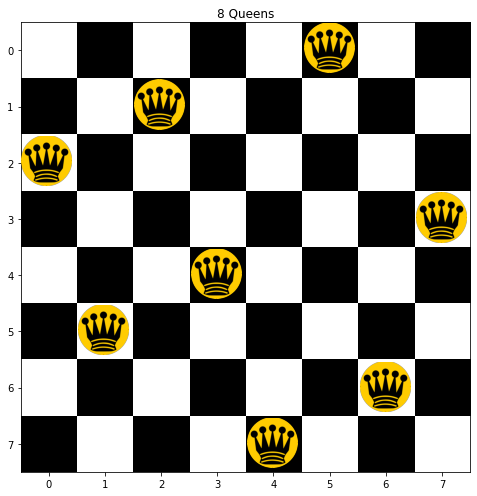

In [13]:
plot_NQueens(solution)

Lets' see if we can find a different solution.

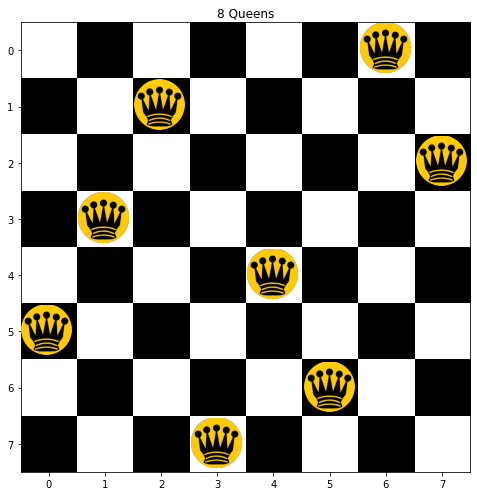

In [14]:
eight_queens = NQueensCSP(8)
solution = min_conflicts(eight_queens)
plot_NQueens(solution)

The solution is a bit different this time. 
Running the above cell several times should give you different valid solutions.
<br>
In the `search.ipynb` notebook, we will see how NQueensProblem can be solved using a **heuristic search method** such as `uniform_cost_search` and `astar_search`.

### Helper Functions

We will now implement a few helper functions that will allow us to visualize the Coloring Problem; we'll also make a few modifications to the existing classes and functions for additional record keeping. To begin, we modify the **assign** and **unassign** methods in the **CSP** in order to add a copy of the assignment to the **assignment_history**. We name this new class as **InstruCSP**; it will allow us to see how the assignment evolves over time. 

In [15]:
import copy
class InstruCSP(CSP):
    
    def __init__(self, variables, domains, neighbors, constraints):
        super().__init__(variables, domains, neighbors, constraints)
        self.assignment_history = []
        
    def assign(self, var, val, assignment):
        super().assign(var,val, assignment)
        self.assignment_history.append(copy.deepcopy(assignment))
    
    def unassign(self, var, assignment):
        super().unassign(var,assignment)
        self.assignment_history.append(copy.deepcopy(assignment))

Next, we define **make_instru** which takes an instance of **CSP** and returns an instance of **InstruCSP**.

In [16]:
def make_instru(csp):
    return InstruCSP(csp.variables, csp.domains, csp.neighbors, csp.constraints)

We will now use a graph defined as a dictionary for plotting purposes in our Graph Coloring Problem. The keys are the nodes and their values are the corresponding nodes they are connected to.

In [17]:
neighbors = {
    0: [6, 11, 15, 18, 4, 11, 6, 15, 18, 4], 
    1: [12, 12, 14, 14], 
    2: [17, 6, 11, 6, 11, 10, 17, 14, 10, 14], 
    3: [20, 8, 19, 12, 20, 19, 8, 12], 
    4: [11, 0, 18, 5, 18, 5, 11, 0], 
    5: [4, 4], 
    6: [8, 15, 0, 11, 2, 14, 8, 11, 15, 2, 0, 14], 
    7: [13, 16, 13, 16], 
    8: [19, 15, 6, 14, 12, 3, 6, 15, 19, 12, 3, 14], 
    9: [20, 15, 19, 16, 15, 19, 20, 16], 
    10: [17, 11, 2, 11, 17, 2], 
    11: [6, 0, 4, 10, 2, 6, 2, 0, 10, 4], 
    12: [8, 3, 8, 14, 1, 3, 1, 14], 
    13: [7, 15, 18, 15, 16, 7, 18, 16], 
    14: [8, 6, 2, 12, 1, 8, 6, 2, 1, 12], 
    15: [8, 6, 16, 13, 18, 0, 6, 8, 19, 9, 0, 19, 13, 18, 9, 16], 
    16: [7, 15, 13, 9, 7, 13, 15, 9], 
    17: [10, 2, 2, 10], 
    18: [15, 0, 13, 4, 0, 15, 13, 4], 
    19: [20, 8, 15, 9, 15, 8, 3, 20, 3, 9], 
    20: [3, 19, 9, 19, 3, 9]
}

Now we are ready to create an InstruCSP instance for our problem. We are doing this for an instance of **MapColoringProblem** class which inherits from the **CSP** Class. This means that our **make_instru** function will work perfectly for it.

In [18]:
coloring_problem = MapColoringCSP('RGBY', neighbors)

In [19]:
coloring_problem1 = make_instru(coloring_problem)

### CONSTRAINT PROPAGATION
Algorithms that solve CSPs have a choice between searching and or doing a _constraint propagation_, a specific type of inference.
The constraints can be used to reduce the number of legal values for another variable, which in turn can reduce the legal values for some other variable, and so on. 
<br>
Constraint propagation tries to enforce _local consistency_.
Consider each variable as a node in a graph and each binary constraint as an arc.
Enforcing local consistency causes inconsistent values to be eliminated throughout the graph, 
a lot like the `GraphPlan` algorithm in planning, where mutex links are removed from a planning graph.
There are different types of local consistencies:
1. Node consistency
2. Arc consistency
3. Path consistency
4. K-consistency
5. Global constraints

Refer __section 6.2__ in the book for details.
<br>

## AC-3
Before we dive into AC-3, we need to know what _arc-consistency_ is.
<br>
A variable $X_i$ is __arc-consistent__ with respect to another variable $X_j$ if for every value in the current domain $D_i$ there is some value in the domain $D_j$ that satisfies the binary constraint on the arc $(X_i, X_j)$.
<br>
A network is arc-consistent if every variable is arc-consistent with every other variable.
<br>

AC-3 is an algorithm that enforces arc consistency.
After applying AC-3, either every arc is arc-consistent, or some variable has an empty domain, indicating that the CSP cannot be solved.
Let's see how `AC3` is implemented in the module.

In [20]:
%psource AC3

def AC3(csp, queue=None, removals=None, arc_heuristic=dom_j_up):
    """[Figure 6.3]"""
    if queue is None:
        queue = {(Xi, Xk) for Xi in csp.variables for Xk in csp.neighbors[Xi]}
    csp.support_pruning()
    queue = arc_heuristic(csp, queue)
    checks = 0
    while queue:
        (Xi, Xj) = queue.pop()
        revised, checks = revise(csp, Xi, Xj, removals, checks)
        if revised:
            if not csp.curr_domains[Xi]:
                return False, checks  # CSP is inconsistent
            for Xk in csp.neighbors[Xi]:
                if Xk != Xj:
                    queue.add((Xk, Xi))
    return True, checks  # CSP is satisfiable


`AC3` also employs a helper function `revise`.

In [21]:
%psource revise

def revise(csp, Xi, Xj, removals, checks=0):
    """Return true if we remove a value."""
    revised = False
    for x in csp.curr_domains[Xi][:]:
        # If Xi=x conflicts with Xj=y for every possible y, eliminate Xi=x
        # if all(not csp.constraints(Xi, x, Xj, y) for y in csp.curr_domains[Xj]):
        conflict = True
        for y in csp.curr_domains[Xj]:
            if csp.constraints(Xi, x, Xj, y):
                conflict = False
            checks += 1
            if not conflict:
                break
        if conflict:
            csp.prune(Xi, x, removals)
            revised = True
    return revised, checks


`AC3` maintains a queue of arcs to consider which initially contains all the arcs in the CSP.
An arbitrary arc $(X_i, X_j)$ is popped from the queue and $X_i$ is made _arc-consistent_ with respect to $X_j$.
<br>
If in doing so, $D_i$ is left unchanged, the algorithm just moves to the next arc, 
but if the domain $D_i$ is revised, then we add all the neighboring arcs $(X_k, X_i)$ to the queue.
<br>
We repeat this process and if at any point, the domain $D_i$ is reduced to nothing, then we know the whole CSP has no consistent solution and `AC3` can immediately return failure.
<br>
Otherwise, we keep removing values from the domains of variables until the queue is empty.
We finally get the arc-consistent CSP which is faster to search because the variables have smaller domains.

Let's see how `AC3` can be used.
<br>
We'll first define the required variables.

In [22]:
neighbors = parse_neighbors('A: B; B: ')
domains = {'A': [0, 1, 2, 3, 4], 'B': [0, 1, 2, 3, 4]}
constraints = lambda X, x, Y, y: x % 2 == 0 and (x + y) == 4 and y % 2 != 0
removals = []

We'll now define a `CSP` object.

In [23]:
csp = CSP(variables=None, domains=domains, neighbors=neighbors, constraints=constraints)

In [24]:
AC3(csp, removals=removals)

(False, 25)

This configuration is inconsistent.

In [25]:
constraints = lambda X, x, Y, y: (x % 2) == 0 and (x + y) == 4
removals = []
csp = CSP(variables=None, domains=domains, neighbors=neighbors, constraints=constraints)

In [26]:
AC3(csp,removals=removals)

(True, 31)

This configuration is consistent.

## BACKTRACKING SEARCH

The main issue with using Naive Search Algorithms to solve a CSP is that they can continue to expand obviously wrong paths; whereas, in **backtracking search**, we check the constraints as we go and we deal with only one variable at a time. Backtracking Search is implemented in the repository as the function **backtracking_search**. This is the same as **Figure 6.5** in the book. The function takes as input a CSP and a few other optional parameters which can be used to speed it up further. The function returns the correct assignment if it satisfies the goal. However, we will discuss these later. For now, let us solve our **coloring_problem1** with **backtracking_search**.

In [27]:
result = backtracking_search(coloring_problem1)

In [28]:
result # A dictonary of assignments.

{0: 'R',
 1: 'R',
 2: 'R',
 3: 'R',
 4: 'G',
 5: 'R',
 6: 'G',
 7: 'R',
 8: 'B',
 9: 'R',
 10: 'G',
 11: 'B',
 12: 'G',
 13: 'G',
 14: 'Y',
 15: 'Y',
 16: 'B',
 17: 'B',
 18: 'B',
 19: 'G',
 20: 'B'}

Let us also check the number of assignments made.

In [29]:
coloring_problem1.nassigns

21

Now, let us check the total number of assignments and unassignments, which would be the length of our assignment history. We can see it by using the command below. 

In [30]:
len(coloring_problem1.assignment_history)

21

Now let us explore the optional keyword arguments that the **backtracking_search** function takes. These optional arguments help speed up the assignment further. Along with these, we will also point out the methods in the CSP class that help to make this work. 

The first one is **select_unassigned_variable**. It takes in, as a parameter, a function that helps in deciding the order in which the variables will be selected for assignment. We use a heuristic called Most Restricted Variable which is implemented by the function **mrv**. The idea behind **mrv** is to choose the variable with the least legal values left in its domain. The intuition behind selecting the **mrv** or the most constrained variable is that it allows us to encounter failure quickly before going too deep into a tree if we have selected a wrong step before. The **mrv** implementation makes use of another function **num_legal_values** to sort out the variables by the number of legal values left in its domain. This function, in turn, calls the **nconflicts** method of the **CSP** to return such values.

In [31]:
%psource mrv

def mrv(assignment, csp):
    """Minimum-remaining-values heuristic."""
    return argmin_random_tie([v for v in csp.variables if v not in assignment],
                             key=lambda var: num_legal_values(csp, var, assignment))


In [32]:
%psource num_legal_values

def num_legal_values(csp, var, assignment):
    if csp.curr_domains:
        return len(csp.curr_domains[var])
    else:
        return count(csp.nconflicts(var, val, assignment) == 0 for val in csp.domains[var])


In [33]:
%psource CSP.nconflicts

    def nconflicts(self, var, val, assignment):
        """Return the number of conflicts var=val has with other variables."""

        # Subclasses may implement this more efficiently
        def conflict(var2):
            return var2 in assignment and not self.constraints(var, val, var2, assignment[var2])

        return count(conflict(v) for v in self.neighbors[var])


Another ordering related parameter **order_domain_values** governs the value ordering. Here we select the Least Constraining Value which is implemented by the function **lcv**. The idea is to select the value which rules out least number of values in the remaining variables. The intuition behind selecting the **lcv** is that it allows a lot of freedom to assign values later. The idea behind selecting the mrc and lcv makes sense because we need to do all variables but for values, and it's better to try the ones that are likely. So for vars, we face the hard ones first.

In [34]:
%psource lcv

def lcv(var, assignment, csp):
    """Least-constraining-values heuristic."""
    return sorted(csp.choices(var), key=lambda val: csp.nconflicts(var, val, assignment))


Finally, the third parameter **inference** can make use of one of the two techniques called Arc Consistency or Forward Checking. The details of these methods can be found in the **Section 6.3.2** of the book. In short the idea of inference is to detect the possible failure before it occurs and to look ahead to not make mistakes. **mac** and **forward_checking** implement these two techniques. The **CSP** methods **support_pruning**, **suppose**, **prune**, **choices**, **infer_assignment** and **restore** help in using these techniques. You can find out more about these by looking up the source code.

Now let us compare the performance with these parameters enabled vs the default parameters. We will use the Graph Coloring problem instance 'usa' for comparison. We will call the instances **solve_simple** and **solve_parameters** and solve them using backtracking and compare the number of assignments.

In [35]:
solve_simple = copy.deepcopy(usa_csp)
solve_parameters = copy.deepcopy(usa_csp)

In [36]:
backtracking_search(solve_simple)
backtracking_search(solve_parameters, order_domain_values=lcv, select_unassigned_variable=mrv, inference=mac)

{'OH': 'R',
 'IN': 'G',
 'KY': 'B',
 'IL': 'R',
 'MI': 'B',
 'WV': 'G',
 'PA': 'B',
 'WI': 'G',
 'MD': 'R',
 'VA': 'Y',
 'DC': 'G',
 'TN': 'R',
 'IA': 'B',
 'MN': 'R',
 'DE': 'G',
 'MO': 'G',
 'NJ': 'R',
 'NY': 'G',
 'NC': 'G',
 'SD': 'G',
 'ND': 'B',
 'NE': 'R',
 'MT': 'R',
 'AR': 'B',
 'GA': 'B',
 'MS': 'G',
 'AL': 'Y',
 'KA': 'B',
 'SC': 'R',
 'OK': 'R',
 'CO': 'G',
 'FL': 'R',
 'TX': 'G',
 'WY': 'B',
 'UT': 'R',
 'ID': 'G',
 'LA': 'R',
 'NM': 'B',
 'AZ': 'G',
 'NV': 'B',
 'OR': 'R',
 'CA': 'Y',
 'WA': 'B',
 'VT': 'R',
 'MA': 'B',
 'CT': 'R',
 'RI': 'G',
 'NH': 'G',
 'ME': 'R'}

In [37]:
solve_simple.nassigns

49

In [38]:
solve_parameters.nassigns

49

## TREE CSP SOLVER

The `tree_csp_solver` function (**Figure 6.11** in the book) can be used to solve problems whose constraint graph is a tree. Given a CSP, with `neighbors` forming a tree, it returns an assignment that satisfies the given constraints. The algorithm works as follows:

First it finds the *topological sort* of the tree. This is an ordering of the tree where each variable/node comes after its parent in the tree. The function that accomplishes this is `topological_sort`; it builds the topological sort using the recursive function `build_topological`. That function is an augmented DFS (Depth First Search), where each newly visited node of the tree is pushed on a stack. The stack in the end holds the variables topologically sorted.

Then the algorithm makes arcs between each parent and child consistent. *Arc-consistency* between two variables, *a* and *b*, occurs when for every possible value of *a* there is an assignment in *b* that satisfies the problem's constraints. If such an assignment cannot be found, the problematic value is removed from *a*'s possible values. This is done with the use of the function `make_arc_consistent`, which takes as arguments a variable `Xj` and its parent, and makes the arc between them consistent by removing any values from the parent which do not allow for a consistent assignment in `Xj`.

If an arc cannot be made consistent, the solver fails. If every arc is made consistent, we move to assigning values.

First we assign a random value to the root from its domain and then we assign values to the rest of the variables. Since the graph is now arc-consistent, we can simply move from variable to variable picking any remaining consistent values. At the end we are left with a valid assignment. If at any point though we find a variable where no consistent value is left in its domain, the solver fails.

Run the cell below to see the implementation of the algorithm:

In [39]:
%psource tree_csp_solver

def tree_csp_solver(csp):
    """[Figure 6.11]"""
    assignment = {}
    root = csp.variables[0]
    X, parent = topological_sort(csp, root)

    csp.support_pruning()
    for Xj in reversed(X[1:]):
        if not make_arc_consistent(parent[Xj], Xj, csp):
            return None

    assignment[root] = csp.curr_domains[root][0]
    for Xi in X[1:]:
        assignment[Xi] = assign_value(parent[Xi], Xi, csp, assignment)
        if not assignment[Xi]:
            return None
    return assignment


We will now use the above function to solve a problem. More specifically, we will solve the problem of coloring Australia's map. We have two colors at our disposal: Red and Blue. As a reminder, this is the graph of Australia:

`"SA: WA NT Q NSW V; NT: WA Q; NSW: Q V; T: "`

Unfortunately, as you can see, the above is not a tree. However, if we remove `SA`, which has arcs to `WA`, `NT`, `Q`, `NSW` and `V`, we are left with a tree (we also remove `T`, since it has no in-or-out arcs). We can now solve this using our algorithm. Let's define the map coloring problem at hand:

In [40]:
australia_small = MapColoringCSP(list('RB'),
                           'NT: WA Q; NSW: Q V')

We will input `australia_small` to the `tree_csp_solver` and print the given assignment.

In [41]:
assignment = tree_csp_solver(australia_small)
print(assignment)

{'NT': 'R', 'Q': 'B', 'NSW': 'R', 'V': 'B', 'WA': 'B'}


`WA`, `Q` and `V` got painted with the same color and `NT` and `NSW` got painted with the other.

## GRAPH COLORING VISUALIZATION

Next, we define some functions to create the visualisation from the assignment_history of **coloring_problem1**. The readers need not concern themselves with the code that immediately follows as it is the usage of Matplotib with IPython Widgets. If you are interested in reading more about these, visit [ipywidgets.readthedocs.io](http://ipywidgets.readthedocs.io). We will be using the **networkx** library to generate graphs. These graphs can be treated as graphs that need to be colored or as constraint graphs for this problem. If interested you can check out a fairly simple tutorial [here](https://www.udacity.com/wiki/creating-network-graphs-with-python). We start by importing the necessary libraries and initializing matplotlib inline.


In [42]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import time

The ipython widgets we will be using require the plots in the form of a step function such that there is a graph corresponding to each value. We define the **make_update_step_function** which returns such a function. It takes in as inputs the neighbors/graph along with an instance of the **InstruCSP**. The example below will elaborate it further. If this sounds confusing, don't worry. This is not part of the core material and our only goal is to help you visualize how the process works.

In [43]:
def make_update_step_function(graph, instru_csp):
    
    #define a function to draw the graphs
    def draw_graph(graph):
        
        G=nx.Graph(graph)
        pos = nx.spring_layout(G,k=0.15)
        return (G, pos)
    
    G, pos = draw_graph(graph)
    
    def update_step(iteration):
        # here iteration is the index of the assignment_history we want to visualize.
        current = instru_csp.assignment_history[iteration]
        #  We convert the particular assignment to a default dict so that the color for nodes which 
        # have not been assigned defaults to black.
        current = defaultdict(lambda: 'Black', current)

        # Now we use colors in the list and default to black otherwise.
        colors = [current[node] for node in G.node.keys()]
        # Finally drawing the nodes.
        nx.draw(G, pos, node_color=colors, node_size=500)

        labels = {label:label for label in G.node}
        # Labels shifted by offset so that nodes don't overlap
        label_pos = {key:[value[0], value[1]+0.03] for key, value in pos.items()}
        nx.draw_networkx_labels(G, label_pos, labels, font_size=20)

        # display the graph
        plt.show()

    return update_step  # <-- this is a function

def make_visualize(slider):
    ''' Takes an input a slider and returns 
        callback function for timer and animation
    '''
    
    def visualize_callback(Visualize, time_step):
        if Visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))
    
    return visualize_callback
    

Finally let us plot our problem. We first use the function below to obtain a step function.

In [44]:
step_func = make_update_step_function(neighbors, coloring_problem1)

Next, we set the canvas size.

In [45]:
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)

Finally, our plot using ipywidget slider and matplotib. You can move the slider to experiment and see the colors change. It is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. The **Extra Delay Box** allows you to set time delay in seconds (upto one second) for each time step.

In [46]:
import ipywidgets as widgets
from IPython.display import display

iteration_slider = widgets.IntSlider(min=0, max=len(coloring_problem1.assignment_history)-1, step=1, value=0)
w=widgets.interactive(step_func,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=0, description='iteration', max=20), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…

## N-QUEENS VISUALIZATION

Just like the Graph Coloring Problem, we will start with defining a few helper functions to help us visualize the assignments as they evolve over time. The **make_plot_board_step_function** behaves similar to the **make_update_step_function** introduced earlier. It initializes a chess board in the form of a 2D grid with alternating 0s and 1s. This is used by **plot_board_step** function which draws the board using matplotlib and adds queens to it. This function also calls the **label_queen_conflicts** which modifies the grid placing a 3 in any position where there is a conflict.

In [47]:
def label_queen_conflicts(assignment,grid):
    ''' Mark grid with queens that are under conflict. '''
    for col, row in assignment.items(): # check each queen for conflict
        conflicts = {temp_col:temp_row for temp_col,temp_row in assignment.items() 
                         if (temp_row == row and temp_col != col)
                          or (temp_row+temp_col == row+col and temp_col != col)
                          or (temp_row-temp_col == row-col and temp_col != col)}
        
        # Place a 3 in positions where this is a conflict
        for col, row in conflicts.items():
                grid[col][row] = 3

    return grid

def make_plot_board_step_function(instru_csp):
    '''ipywidgets interactive function supports
       single parameter as input. This function
       creates and return such a function by taking
       in input other parameters.
    '''
    n = len(instru_csp.variables)
    
    
    def plot_board_step(iteration):
        ''' Add Queens to the Board.'''
        data = instru_csp.assignment_history[iteration]
        
        grid = [[(col+row+1)%2 for col in range(n)] for row in range(n)]
        grid = label_queen_conflicts(data, grid) # Update grid with conflict labels.
        
        # color map of fixed colors
        cmap = matplotlib.colors.ListedColormap(['white','lightsteelblue','red'])
        bounds=[0,1,2,3] # 0 for white 1 for black 2 onwards for conflict labels (red).
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        
        fig = plt.imshow(grid, interpolation='nearest', cmap = cmap,norm=norm)

        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

        # Place the Queens Unicode Symbol
        for col, row in data.items():
            fig.axes.text(row, col, u"\u265B", va='center', ha='center', family='Dejavu Sans', fontsize=32)
        plt.show()
    
    return plot_board_step

Now let us visualize a solution obtained via backtracking. We make use of the previosuly defined **make_instru** function for keeping a history of steps.

In [48]:
twelve_queens_csp = NQueensCSP(12)
backtracking_instru_queen = make_instru(twelve_queens_csp)
result = backtracking_search(backtracking_instru_queen)

In [49]:
backtrack_queen_step = make_plot_board_step_function(backtracking_instru_queen) # Step Function for Widgets

Now finally we set some matplotlib parameters to adjust how our plot will look like. The font is necessary because the Black Queen Unicode character is not a part of all fonts. You can move the slider to experiment and observe how the queens are assigned. It is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. The **Extra Delay Box** allows you to set time delay in seconds of upto one second for each time step.

In [50]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['font.family'].append(u'Dejavu Sans')

iteration_slider = widgets.IntSlider(min=0, max=len(backtracking_instru_queen.assignment_history)-1, step=0, value=0)
w=widgets.interactive(backtrack_queen_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=0, description='iteration', max=473, step=0), Output()), _dom_classes=('…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…

Now let us finally repeat the above steps for **min_conflicts** solution.

In [51]:
conflicts_instru_queen = make_instru(twelve_queens_csp)
result = min_conflicts(conflicts_instru_queen)

In [52]:
conflicts_step = make_plot_board_step_function(conflicts_instru_queen)

This visualization has same features as the one above; however, this one also highlights the conflicts by labeling the conflicted queens with a red background.

In [53]:
iteration_slider = widgets.IntSlider(min=0, max=len(conflicts_instru_queen.assignment_history)-1, step=0, value=0)
w=widgets.interactive(conflicts_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=0, description='iteration', max=21, step=0), Output()), _dom_classes=('w…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…